## Introdução

O mercado de opções é uma área complexa e dinâmica das finanças, onde instrumentos derivados são utilizados para hedging, especulação e otimização de portfólios. A correta avaliação dos preços de opções é crucial para investidores e analistas financeiros, uma vez que as decisões de compra e venda podem impactar significativamente o desempenho financeiro. O modelo Black-Merton-Scholes (BMS), desenvolvido na década de 1970, é um dos métodos mais amplamente utilizados para a precificação de opções europeias, fornecendo uma fórmula analítica que leva em consideração fatores como preço do ativo subjacente, taxa de juros e volatilidade.

Embora o modelo BMS tenha se mostrado eficaz na precificação de opções sob determinadas condições, sua aplicação prática enfrenta desafios devido à complexidade do comportamento do mercado e à incerteza das variáveis envolvidas. Para superar essas limitações, a inteligência artificial, em particular as redes neurais, emergiu como uma ferramenta promissora para modelar e prever comportamentos complexos em séries temporais financeiras.

Neste projeto, buscamos explorar a eficácia das redes neurais na previsão de preços de opções, utilizando dados sintéticos gerados pelo modelo BMS. O objetivo é avaliar como diferentes configurações de treinamento, variando o número de épocas, afetam a capacidade do modelo de capturar a dinâmica dos preços. Através da comparação das previsões da rede neural com os dados reais gerados pelo modelo BMS, esperamos proporcionar uma análise abrangente da aplicabilidade de técnicas de aprendizado de máquina na avaliação de opções.

A abordagem proposta não apenas contribui para a compreensão das interações entre o modelo BMS e redes neurais, mas também oferece insights sobre o potencial de modelos baseados em aprendizado de máquina na evolução da precificação de opções no contexto financeiro contemporâneo.

In [59]:
!pip install -q -U watermark

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.8 MB/s eta 0:00:00


In [57]:
# Bibliotecas
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import pickle

In [60]:
# Versões dos pacotes usados neste notebook
%reload_ext watermark
%watermark -a "Winicius B. Faquieri" --iversions

Author: Winicius B. Faquieri

seaborn   : 0.13.2
scipy     : 1.13.1
matplotlib: 3.7.1
pandas    : 2.2.2
numpy     : 1.26.4
sklearn   : 1.5.2



In [24]:
# Classe para a camada densa
class Dense:

    # Método construtor
    def __init__(self, feat_size, out_size):
        self.feat_size = feat_size
        self.out_size = out_size
        self.weights = (np.random.normal(0, 1, feat_size * out_size) * np.sqrt(2 / feat_size)).reshape(feat_size, out_size)
        self.bias = np.random.rand(1, out_size) - 0.5

    # Método da passada linear para frente
    def forward(self, input_data):
        self.input = input_data
        self.output = np.dot(self.input, self.weights) + self.bias
        return(self.output)

    # Método da passada de volta (backpropagation)
    def backward(self, output_der, lr):
        input_der = np.dot(output_der, self.weights.T)
        weight_der = np.dot(self.input.T.reshape(-1, 1), output_der)
        self.weights -= lr * weight_der
        self.bias -= lr * output_der
        return(input_der)

In [25]:
# Função de ativação
def relu(x):
    return(np.maximum(0, x))

# Derivada da função de ativação
def relu_prime(x):
    x[x > 0] = 1
    x[x <= 0] = 0
    return x

In [26]:
# Classe da camada de ativação
class ActLayer:

    # Método construtor
    def __init__(self, act, act_prime):
        self.act = act
        self.act_prime = act_prime

    # Recebe a entrada (input) e retorna a saída da função de ativação
    def forward(self, input_data):
        self.input = input_data
        self.output = self.act(self.input)
        return(self.output)

    # Observe que não estamos atualizando nenhum parâmetro aqui
    # Usamos a taxa de aprendizagem como parâmetro porque definiremos o método de ajuste de uma forma
    # que todas as camadas o exigirão.
    def backward(self, output_der, lr):
        return(self.act_prime(self.input) * output_der)

In [27]:
# Usaremos a Mean-Squared-Error como função de perda
def mse(y_true, y_pred):
    return(np.mean((y_pred - y_true)**2))

# Derivada da função de perda
def mse_prime(y_true, y_pred):
    return(2*(y_pred - y_true) / y_true.size)

In [28]:
# Modelo
class Network:

    # Método construtor
    # Inicializa com a função de perda e sua derivada
    def __init__(self, loss, loss_prime):
        self.layers = []
        self.loss = loss
        self.loss_prime = loss_prime

    # Método para adicionar camadas ao grafo computacional
    def add(self, layer):
        self.layers.append(layer)

    # Implementando apenas forward-pass para predição
    def predict(self, input_data):

        # Lista para o resultado
        result = []

        for a in range(len(input_data)):

            # Camada de saída
            layer_output = input_data[a]

            # Loop pelas camadas
            for layer in self.layers:

                # Movendo vetores de camada para camada
                layer_output = layer.forward(layer_output)

            result.append(layer_output)

        return(result)

    # Método de treinamento
    def fit(self, X_train, y_train, epochs, lr):

        # Número de iterações
        for a in range(epochs):

            # Inicializa a variável de cálculo do erro
            err = 0

            # Temos 1 passagem para a frente e para trás para cada ponto de dados
            # Esse algoritmo de aprendizagem usa a Descida Estocástica do Gradiente
            for j in range(len(X_train)):

                # Camada de saída
                layer_output = X_train[j]

                # Loop pelas camadas
                for layer in self.layers:
                    layer_output = layer.forward(layer_output)

                # Vamos guardar o erro e mostrar durante o treinamento
                err += self.loss(y_train[j], layer_output)

                # Observe que fazemos o loop nas camadas em ordem reversa.
                # Inicialmente calculamos a derivada da perda com relação à previsão.
                # Em seguida, a camada de saída irá calcular a derivada em relação à sua entrada
                # e irá passar esta derivada de entrada para a camada anterior que corresponde à sua derivada de saída
                # e essa camada repetirá o mesmo processo, passando sua derivada de entrada para a camada anterior.

                # dL/dY_hat # Cálculo do gradiente
                gradient = self.loss_prime(y_train[j], layer_output)

                # Este loop é a razão de termos dado lr à camada de ativação como argumento
                for layer in reversed(self.layers):

                    # Definindo gradiente para dY / dh_ {i + 1} da camada atual
                    gradient = layer.backward(gradient, lr)

            err /= len(X_train)

            print('Epoch %d/%d   Erro = %f' % (a + 1, epochs, err))

## Testando o modelo com o XOR

O teste com o problema XOR (ou "OU Exclusivo") é uma forma comum de avaliar a capacidade de modelos de aprendizado de máquina, especialmente redes neurais, de resolver problemas não linearmente separáveis.

XOR é conhecido por ser não linearmente separável, o que significa que você não pode separar as classes de saída (0 e 1) apenas com uma linha reta. Essa característica o torna um problema de teste comum para modelos que precisam de mais camadas ou de funções de ativação não lineares para poder resolvê-lo, como é o caso das redes neurais com camadas ocultas.

In [29]:
# Dados
x_train = np.array([[[0, 0]], [[0, 1]], [[1, 0]], [[1, 1]]])
y_train = np.array([[[0]], [[1]], [[1]], [[0]]])

# Ajuste dos dados
x_train = x_train.reshape(-1, 2)
y_train = y_train.reshape(-1, 1)

# Modelo
modelo_xor = Network(mse, mse_prime)
modelo_xor.add(Dense(2, 3))
modelo_xor.add(ActLayer(relu, relu_prime))
modelo_xor.add(Dense(3, 1))

# Treinamento
modelo_xor.fit(x_train, y_train, epochs = 2000, lr = 0.01)

# Teste
y_pred = modelo_xor.predict(x_train)

Epoch 1/2000   Erro = 0.421722
Epoch 2/2000   Erro = 0.388404
Epoch 3/2000   Erro = 0.361524
Epoch 4/2000   Erro = 0.339738
Epoch 5/2000   Erro = 0.322008
Epoch 6/2000   Erro = 0.307523
Epoch 7/2000   Erro = 0.295646
Epoch 8/2000   Erro = 0.285871
Epoch 9/2000   Erro = 0.277796
Epoch 10/2000   Erro = 0.271097
Epoch 11/2000   Erro = 0.265516
Epoch 12/2000   Erro = 0.260844
Epoch 13/2000   Erro = 0.256913
Epoch 14/2000   Erro = 0.253585
Epoch 15/2000   Erro = 0.250749
Epoch 16/2000   Erro = 0.248315
Epoch 17/2000   Erro = 0.246209
Epoch 18/2000   Erro = 0.244371
Epoch 19/2000   Erro = 0.242753
Epoch 20/2000   Erro = 0.241314
Epoch 21/2000   Erro = 0.240021
Epoch 22/2000   Erro = 0.238847
Epoch 23/2000   Erro = 0.237772
Epoch 24/2000   Erro = 0.236775
Epoch 25/2000   Erro = 0.235844
Epoch 26/2000   Erro = 0.234965
Epoch 27/2000   Erro = 0.234130
Epoch 28/2000   Erro = 0.233328
Epoch 29/2000   Erro = 0.232555
Epoch 30/2000   Erro = 0.231804
Epoch 31/2000   Erro = 0.231070
Epoch 32/2000   E

Para que o teste seja bem-sucedido, o modelo precisa prever corretamente as saídas do problema XOR (0, 1, 1, 0).



In [31]:
print("Valor Real:", "\n",
      list(y_train.reshape(-1,)), "\n",
      "------------", "\n",
      "Valor Previsto:", "\n",
      [round(float(a)) for a in y_pred])

Valor Real: 
 [0, 1, 1, 0] 
 ------------ 
 Valor Previsto: 
 [0, 1, 1, 0]


<ipython-input-31-3149d62bb70a>:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [round(float(a)) for a in y_pred])


## Modelo de Black, Merton e Scholes (BMS)

In [32]:
# Parâmetros para simulação de precificação de opções com o modelo BMS

# Volatilidade (desvio padrão), sigma, utilizado na SDE e PDE
vol = 0.17

# Tempo de maturidade da opção (em anos)
T = 0.5

# Número de etapas para discretização do processo estocástico
n = 1000

# Preço inicial da ação (S_0)
s_0 = 100

# Taxa livre de risco anualizada (r), derivada da SDE
r = 0.05

# Preço de exercício da opção (K)
k = 100

In [33]:
def calculate_spot(prev, sigma, r, step, random):
    return(prev + (sigma*prev*random) + (r*prev*step))

def sim_spot(s0, r, steps, maturity, vol):
    delta_t = T/steps
    time = np.round(np.arange(0, maturity+delta_t, delta_t), 4)
    prices = [s0]
    normal_dist = np.random.normal(0, np.sqrt(delta_t), 10000)
    for a in range(steps):
        prices.append(calculate_spot(prices[-1], vol, r, delta_t, normal_dist[a]))
    return(prices)

In [34]:
# Gerando 5 caminhos diferentes para testar as funções
# Vamos usar apenas 1 caminho no treinamento de rede
sims = pd.DataFrame()
for a in range(5):
    sims[a] = sim_spot(s_0, r, n, T, vol)

# Valores para simulações
sims.columns = ["Sim_1", "Sim_2", "Sim_3", "Sim_4", "Sim_5"]
sims.index = np.round(np.arange(0, 0.5 + (0.5 / 1000), 0.5 / 1000), 4)

[Text(0.5, 0, 'Passos'),
 Text(0, 0.5, 'Preços dos Ativos'),
 Text(0.5, 1.0, 'Simulações')]

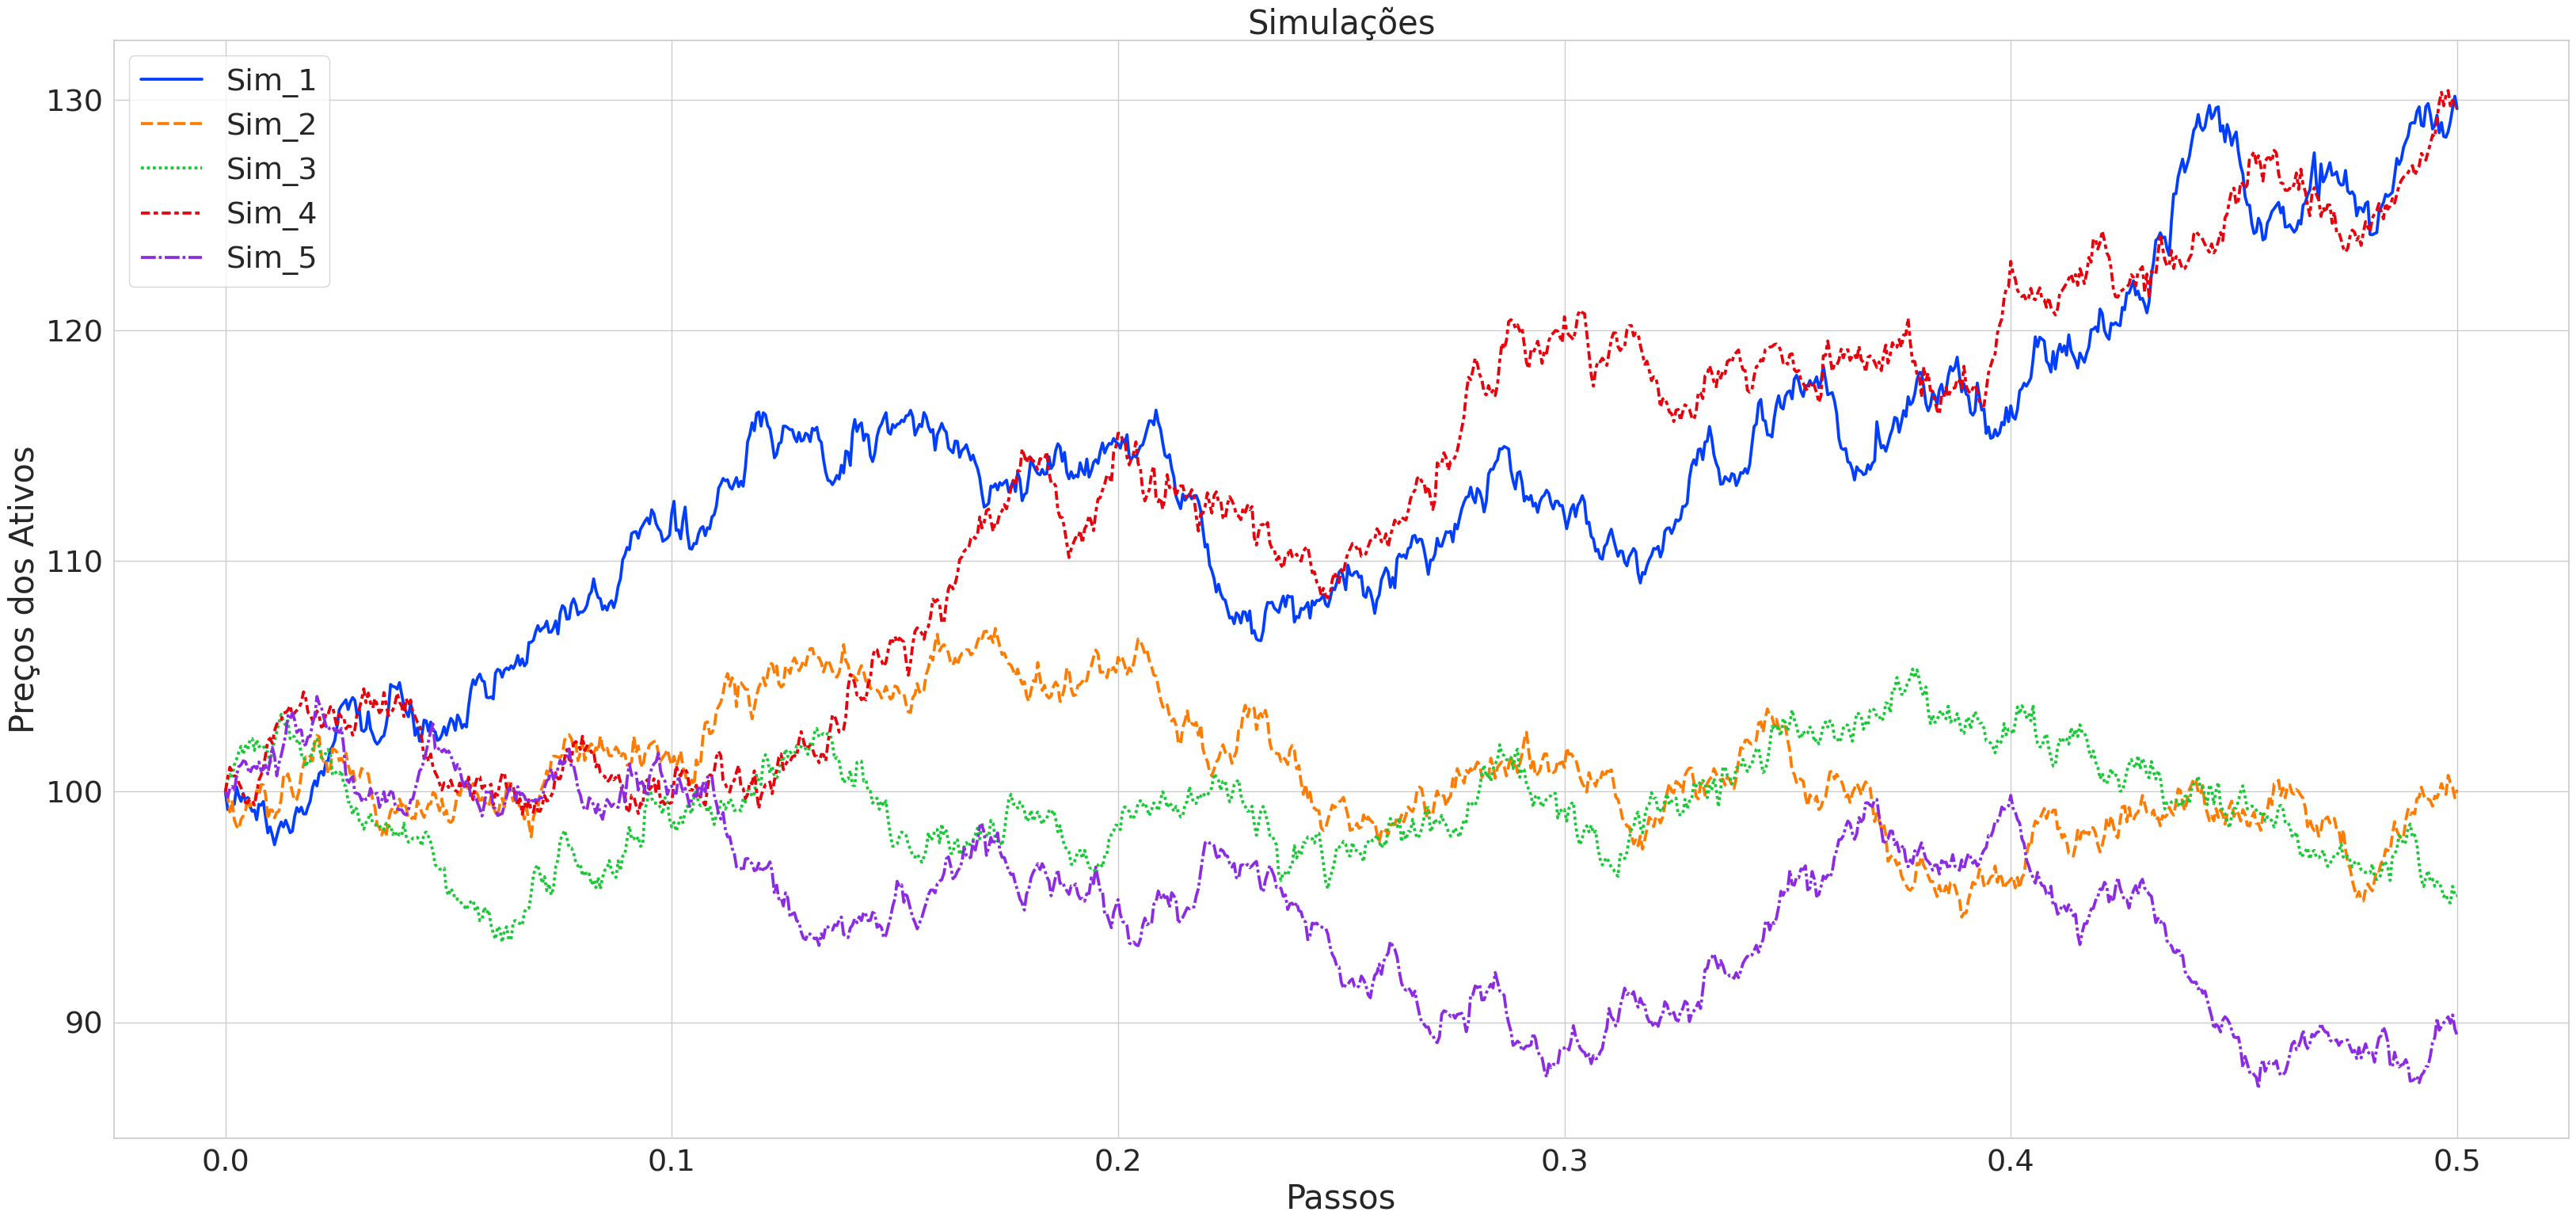

In [ ]:
sns.set(style = "whitegrid", font_scale = 2.5)
plt.figure(figsize = (40, 18))
ax = sns.lineplot(data = sims, palette = "bright", linewidth = 2.7)
ax.set(xlabel = 'Passos', ylabel = 'Preços dos Ativos', title = "Simulações")

In [35]:
def d1(s, k, r, t, T, vol):
    if T != t:
        nomin = np.log(s/k) + (r + 0.5*(vol**2))*(T-t)
        denom = vol*np.sqrt((T-t))
        return(nomin/denom)
    else:
        None


def d2(s, k, r, t, T, vol):
    if T != t:
        nomin = np.log(s/k) + (r - 0.5*(vol**2))*(T-t)
        denom = vol*np.sqrt((T-t))
        return(nomin/denom)
    else:
        None


def call(d1, d2, k, r, T, t, s):
    return(s*scipy.stats.norm.cdf(d1) - k*np.exp(-r*(T-t))*scipy.stats.norm.cdf(d2))

In [36]:
call_prices = []
maturity = []
for (a, b) in zip(sims["Sim_1"], sims.index):
    if b != T:
        d1_ = d1(a, k, r, b, T, vol)
        d2_ = d2(a, k, r, b, T, vol)
        call_prices.append(call(d1_, d2_, k, r, T, b, a))
        maturity.append((T-b))
    else:
        call_prices.append(max(a-k, 0))
        maturity.append(0)

In [37]:
# Dataframe dos preços
opt_price = pd.DataFrame(call_prices, sims.index)
opt_price = opt_price.rename(columns = {0: "Sim_1_Call"})
opt_price = pd.concat([opt_price, sims["Sim_1"]], axis = 1)
min_max = MinMaxScaler(feature_range=(min(call_prices), max(call_prices)))
opt_price["Sim_1_scaled"] = min_max.fit_transform(opt_price["Sim_1"].values.reshape(-1, 1))
opt_price.index = pd.date_range(start = '01/01/2018', end = '06/01/2018', periods = 1001)

In [38]:
opt_price.head()

,Sim_1_Call,Sim_1,Sim_1_scaled
2018-01-01 00:00:00.000,6.069936,100.000000,6.110839
2018-01-01 03:37:26.400,5.868200,99.670078,5.872115
2018-01-01 07:14:52.800,5.829819,99.611624,5.829819
2018-01-01 10:52:19.200,6.110209,100.084540,6.172011
2018-01-01 14:29:45.600,6.437631,100.621423,6.560489


[Text(0.5, 0, 'Data'),
 Text(0, 0.5, 'Preços dos Ativos'),
 Text(0.5, 1.0, 'Preço da Ação - Valor de Venda da Ação')]

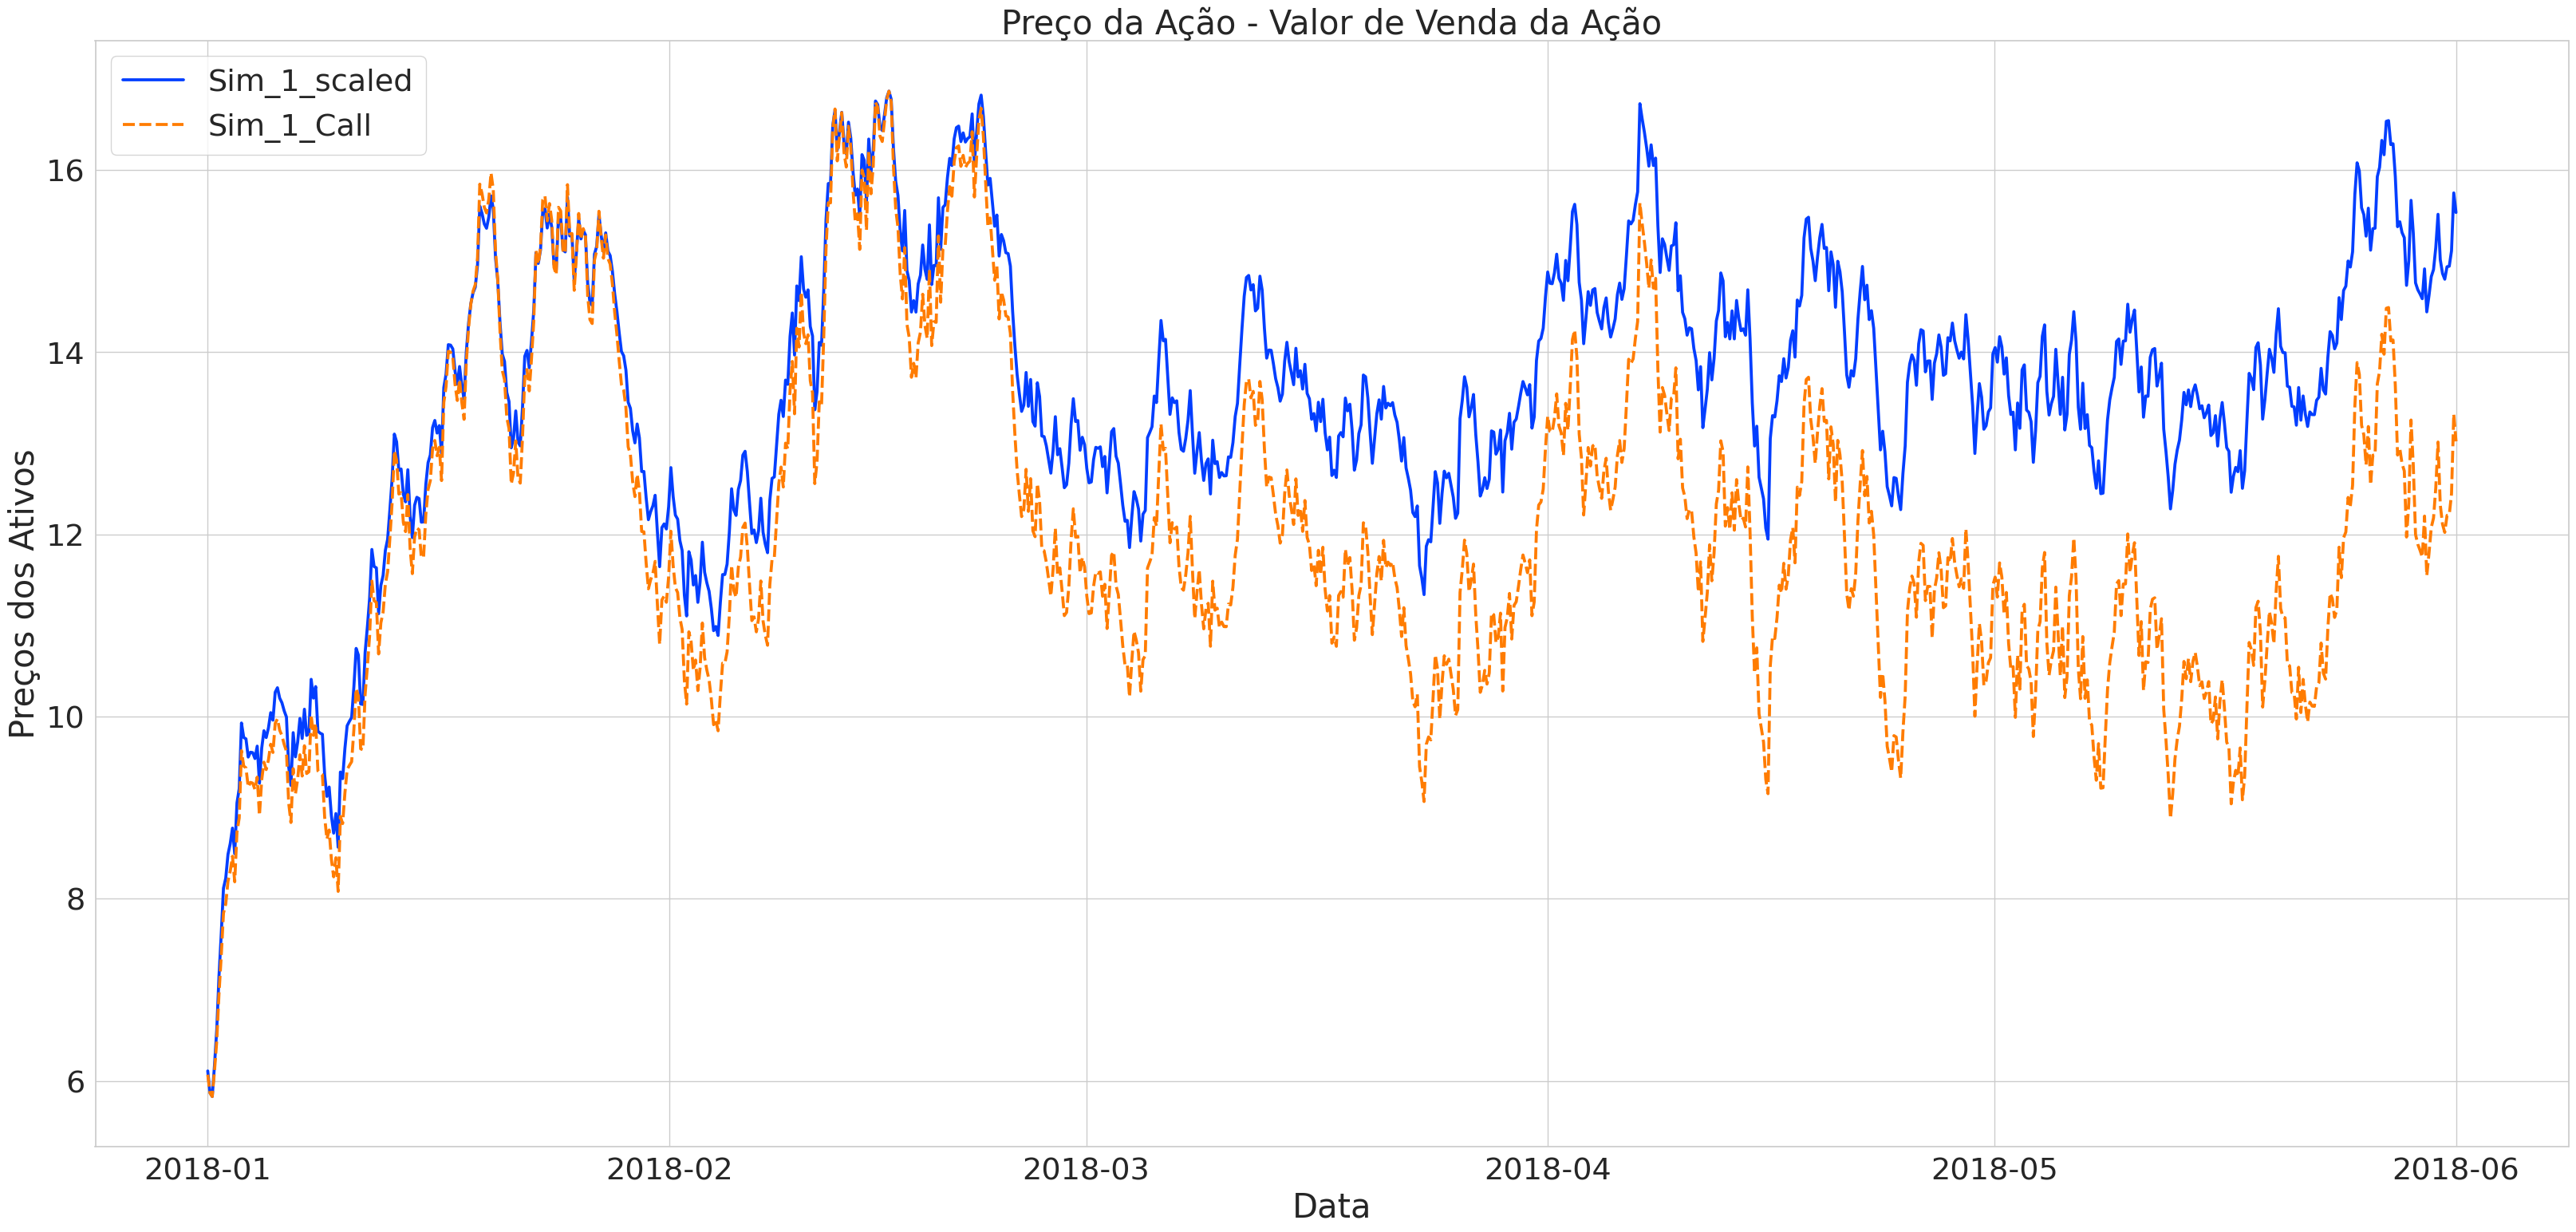

In [39]:
sns.set(style = "whitegrid", font_scale=2.5)
plt.figure(figsize=(40, 18))
ax = sns.lineplot(data = opt_price[["Sim_1_scaled", "Sim_1_Call"]], palette = "bright", linewidth = 2.7)
ax.set(xlabel = 'Data', ylabel = 'Preços dos Ativos', title = "Preço da Ação - Valor de Venda da Ação")

In [40]:
# Dataframe final
opt_price["Maturity"] = maturity
opt_price["Strike"] = k
opt_price["Risk_Free"] = r
opt_price["Volatility"] = vol
model_data = opt_price.drop(["Sim_1_scaled"], axis = 1)

# Visualiza
model_data.head()

,Sim_1_Call,Sim_1,Maturity,Strike,Risk_Free,Volatility
2018-01-01 00:00:00.000,6.069936,100.000000,0.5000,100,0.05,0.17
2018-01-01 03:37:26.400,5.868200,99.670078,0.4995,100,0.05,0.17
2018-01-01 07:14:52.800,5.829819,99.611624,0.4990,100,0.05,0.17
2018-01-01 10:52:19.200,6.110209,100.084540,0.4985,100,0.05,0.17
2018-01-01 14:29:45.600,6.437631,100.621423,0.4980,100,0.05,0.17


In [41]:
# Dados de treino e teste
train_data = model_data.iloc[:round(len(model_data) * 0.8)]
test_data = model_data.iloc[len(train_data):]

X_train = train_data.drop(["Sim_1_Call"], axis = 1).values
y_train = train_data["Sim_1_Call"].values

X_test = test_data.drop(["Sim_1_Call"], axis = 1).values
y_test = test_data["Sim_1_Call"].values

min_max = MinMaxScaler()

X_train = min_max.fit_transform(X_train)
X_test = min_max.transform(X_test)

print("X_train shape:", X_train.shape, "\n",
      "y_train shape:", y_train.shape, "\n",
      "X_test shape:", X_test.shape, "\n",
      "y_test shape:", y_test.shape)

X_train shape: (801, 5) 
 y_train shape: (801,) 
 X_test shape: (200, 5) 
 y_test shape: (200,)


In [42]:
%%time

# Treinando Por 100 Epochs

# Modelo
model = Network(mse, mse_prime)
model.add(Dense(5, 200))
model.add(ActLayer(relu, relu_prime))
model.add(Dense(200, 200))
model.add(ActLayer(relu, relu_prime))
model.add(Dense(200, 200))
model.add(ActLayer(relu, relu_prime))
model.add(Dense(200, 200))
model.add(ActLayer(relu, relu_prime))
model.add(Dense(200, 1))

# Treinamento
model.fit(X_train, y_train, epochs = 100, lr = 0.001)

# Previsões
y_pred_100 = model.predict(X_test)
y_pred_100 = [float(a) for a in y_pred_100]

Epoch 1/100   Erro = 0.157757
Epoch 2/100   Erro = 0.265686
Epoch 3/100   Erro = 0.105739
Epoch 4/100   Erro = 0.051467
Epoch 5/100   Erro = 0.026660
Epoch 6/100   Erro = 0.014337
Epoch 7/100   Erro = 0.008967
Epoch 8/100   Erro = 0.006758
Epoch 9/100   Erro = 0.005710
Epoch 10/100   Erro = 0.005002
Epoch 11/100   Erro = 0.004468
Epoch 12/100   Erro = 0.004024
Epoch 13/100   Erro = 0.003680
Epoch 14/100   Erro = 0.003389
Epoch 15/100   Erro = 0.003159
Epoch 16/100   Erro = 0.002963
Epoch 17/100   Erro = 0.002772
Epoch 18/100   Erro = 0.002583
Epoch 19/100   Erro = 0.002419
Epoch 20/100   Erro = 0.002264
Epoch 21/100   Erro = 0.002116
Epoch 22/100   Erro = 0.001969
Epoch 23/100   Erro = 0.001833
Epoch 24/100   Erro = 0.001701
Epoch 25/100   Erro = 0.001591
Epoch 26/100   Erro = 0.001488
Epoch 27/100   Erro = 0.001387
Epoch 28/100   Erro = 0.001292
Epoch 29/100   Erro = 0.001199
Epoch 30/100   Erro = 0.001115
Epoch 31/100   Erro = 0.001040
Epoch 32/100   Erro = 0.000976
Epoch 33/100   Er

<timed exec>:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


In [43]:
%%time

# Treinando Por 500 Epochsa
model.fit(X_train, y_train, epochs = 500, lr = 0.001)

# Previsões
y_pred_500 = model.predict(X_test)
y_pred_500 = [float(a) for a in y_pred_500]

Epoch 1/500   Erro = 0.346734
Epoch 2/500   Erro = 0.150036
Epoch 3/500   Erro = 0.093103
Epoch 4/500   Erro = 0.061524
Epoch 5/500   Erro = 0.042268
Epoch 6/500   Erro = 0.029879
Epoch 7/500   Erro = 0.021289
Epoch 8/500   Erro = 0.015882
Epoch 9/500   Erro = 0.012569
Epoch 10/500   Erro = 0.010361
Epoch 11/500   Erro = 0.008782
Epoch 12/500   Erro = 0.007805
Epoch 13/500   Erro = 0.007172
Epoch 14/500   Erro = 0.006647
Epoch 15/500   Erro = 0.006206
Epoch 16/500   Erro = 0.005864
Epoch 17/500   Erro = 0.005521
Epoch 18/500   Erro = 0.005249
Epoch 19/500   Erro = 0.005005
Epoch 20/500   Erro = 0.004811
Epoch 21/500   Erro = 0.004583
Epoch 22/500   Erro = 0.004368
Epoch 23/500   Erro = 0.004193
Epoch 24/500   Erro = 0.004002
Epoch 25/500   Erro = 0.003808
Epoch 26/500   Erro = 0.003645
Epoch 27/500   Erro = 0.003509
Epoch 28/500   Erro = 0.003356
Epoch 29/500   Erro = 0.003185
Epoch 30/500   Erro = 0.003056
Epoch 31/500   Erro = 0.002914
Epoch 32/500   Erro = 0.002813
Epoch 33/500   Er

<timed exec>:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


In [ ]:
%%time

# Treinando Por 1000 Epochs
model.fit(X_train, y_train, epochs = 1000, lr = 0.001)

# Previsões
y_pred_1k = model.predict(X_test)
y_pred_1k = [float(a) for a in y_pred_1k]

In [ ]:
# Treinando Por 2000 Epochs
model.fit(X_train, y_train, epochs = 2, lr = 0.001)

# Previsões
y_pred_2k = model.predict(X_test)
y_pred_2k = [float(a) for a in y_pred_2k]

In [ ]:
# Ajusta o shape das perevisões para cada treinamento
y_pred_100 = np.array(y_pred_100).reshape(-1,)
y_pred_500 = np.array(y_pred_500).reshape(-1,)
y_pred_1k = np.array(y_pred_1k).reshape(-1,)
y_pred_2k = np.array(y_pred_2k).reshape(-1,)

In [ ]:
# Dataframe das previsões
all_preds = pd.DataFrame({"Valor_Real": y_test,
                          "100 Epochs": y_pred_100,
                          "500 Epochs": y_pred_500,
                          "1000 Epochs": y_pred_1k,
                          "2000 Epochs": y_pred_2k
                          }, index = test_data.index)

In [62]:
print(all_preds.head())

                         Valor_Real  100 Epochs  500 Epochs  1000 Epochs  \
2018-05-01 22:49:26.400   10.803657   10.827347   10.811723    10.806847   
2018-05-02 02:26:52.800   10.518405   10.552258   10.526747    10.521214   
2018-05-02 06:04:19.200   10.548483   10.580460   10.555216    10.550700   
2018-05-02 09:41:45.600    9.991635   10.062685    9.997966     9.990045   
2018-05-02 13:19:12.000   10.677569   10.703532   10.680146    10.678389   

                         2000 Epochs  
2018-05-01 22:49:26.400    10.805168  
2018-05-02 02:26:52.800    10.519192  
2018-05-02 06:04:19.200    10.548578  
2018-05-02 09:41:45.600     9.989446  
2018-05-02 13:19:12.000    10.676103  


## Visualizar a Performance do Modelo
O objetivo aqui é comparar visualmente as previsões do modelo com os valores reais em diferentes épocas de treinamento. Isso ajuda a entender como bem o modelo se ajustou aos dados e se suas previsões seguem a tendência dos valores reais.

[Text(0.5, 0, 'Data'),
 Text(0, 0.5, 'Preço do Ativo'),
 Text(0.5, 1.0, 'Após 100 Epochs,  MSE:0.249')]

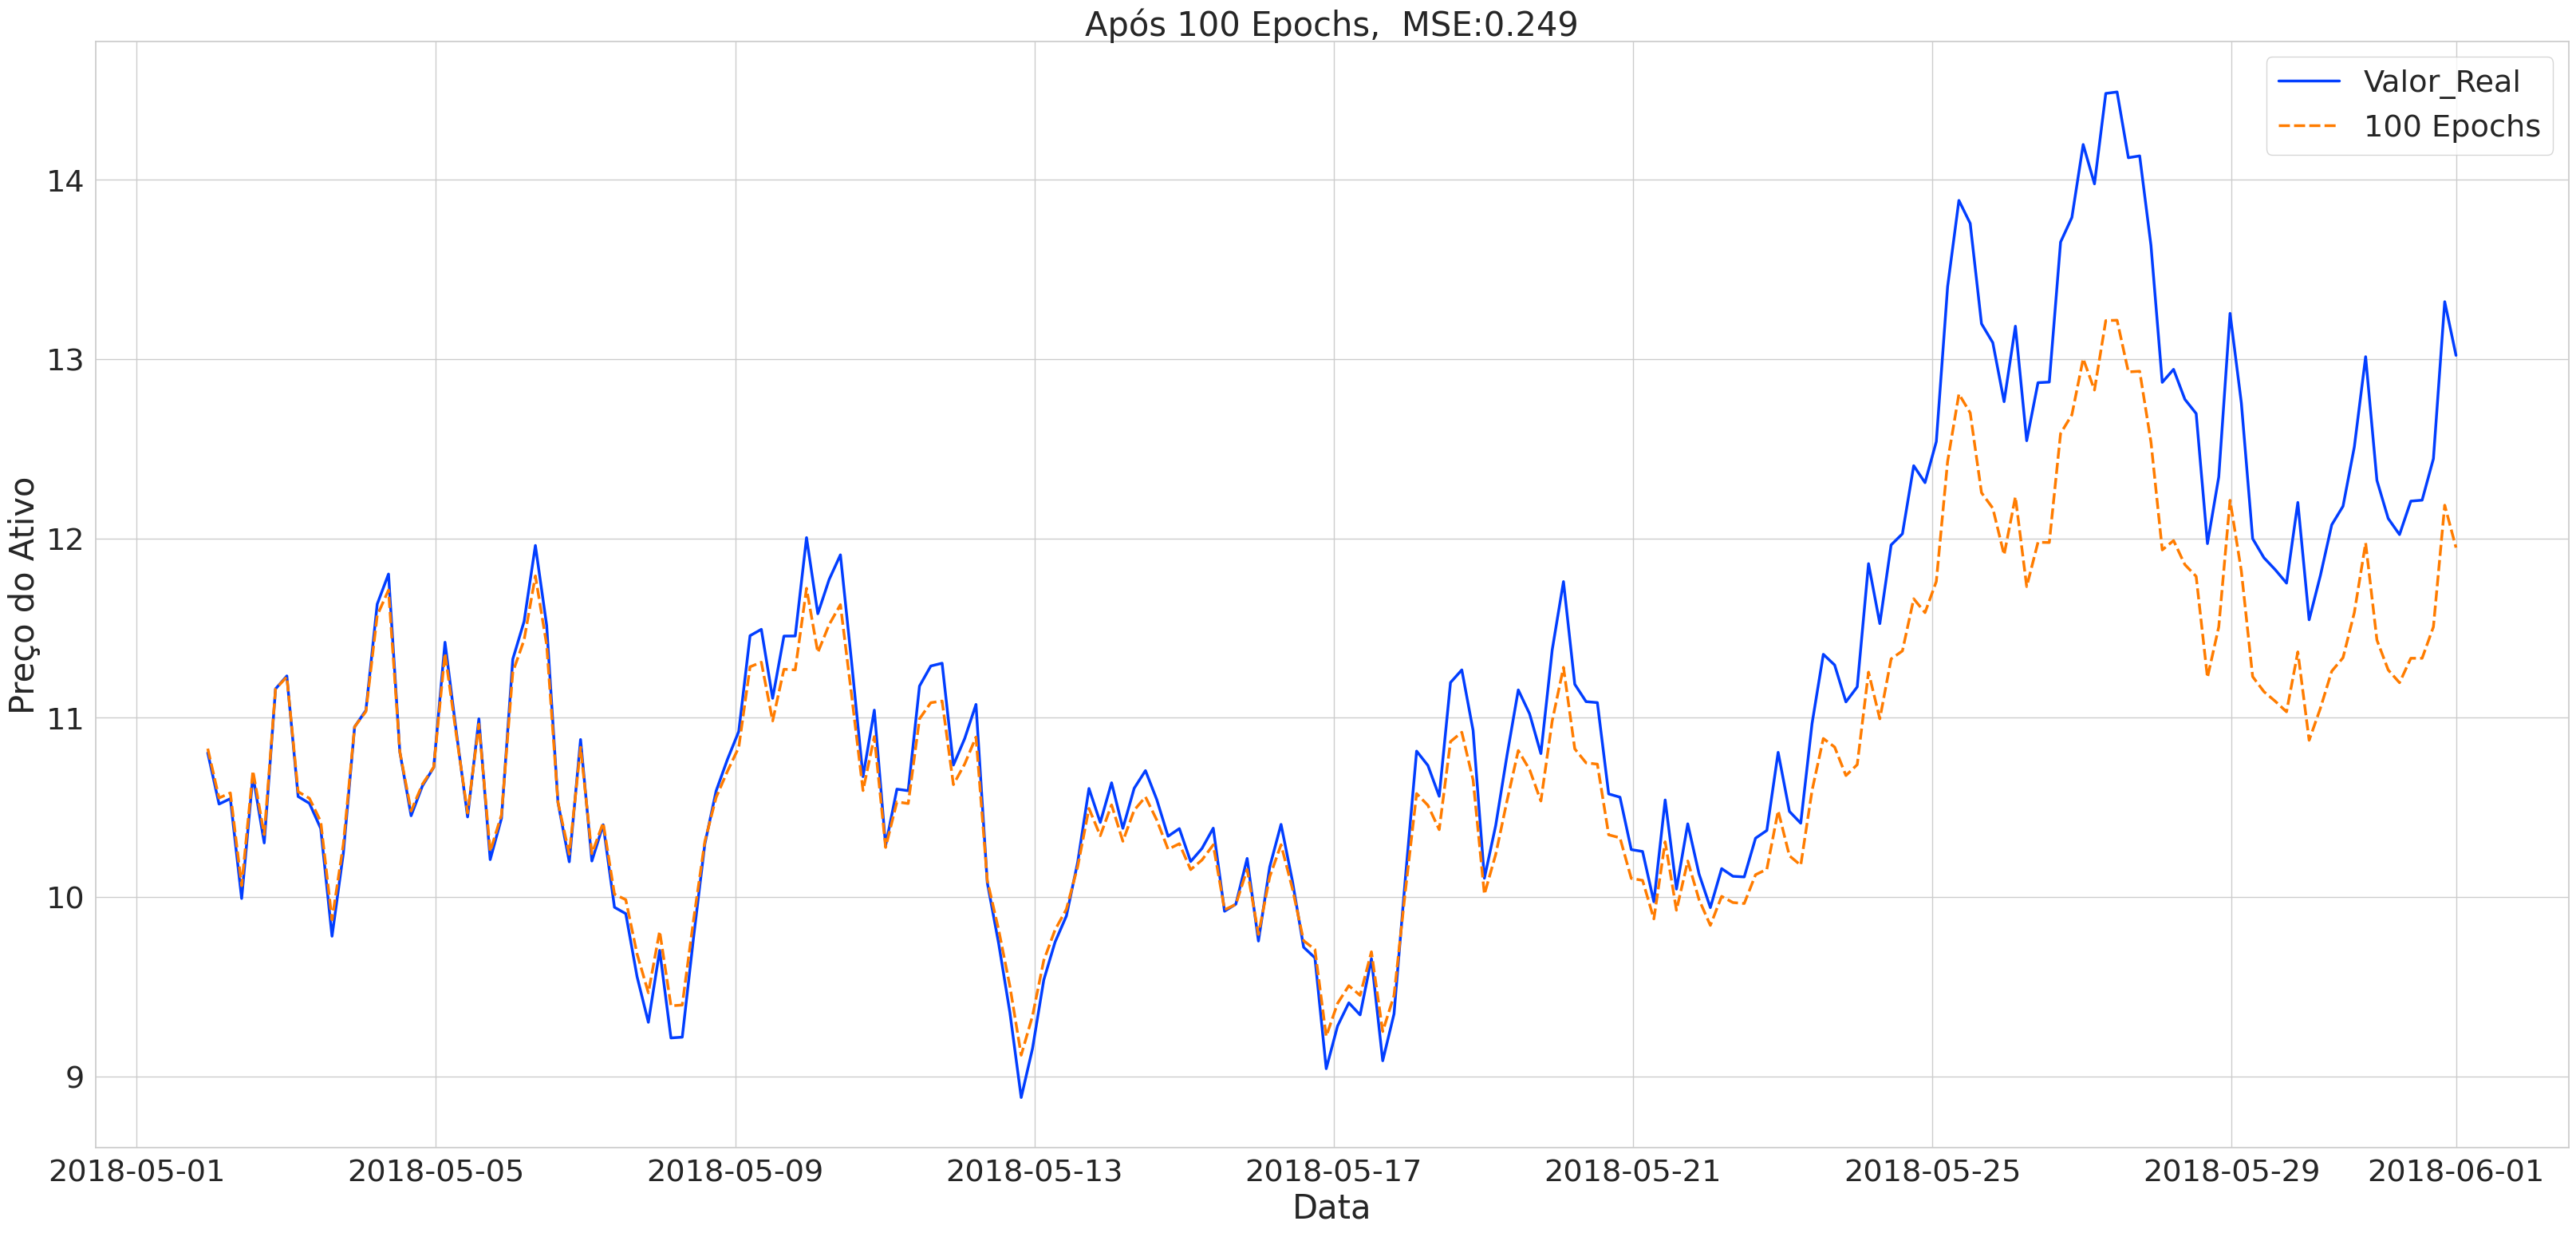

In [48]:
# Plot
plt.figure(figsize = (40, 18))
ax = sns.lineplot(data = all_preds[["Valor_Real", "100 Epochs"]], palette = "bright", linewidth = 2.5)
ax.set(xlabel = 'Data',
       ylabel = 'Preço do Ativo',
       title = f'Após 100 Epochs,  MSE:{round(mean_squared_error(all_preds.Valor_Real, all_preds["100 Epochs"]), 3)}')

[Text(0.5, 0, 'Data'),
 Text(0, 0.5, 'Preço do Ativo'),
 Text(0.5, 1.0, 'Após 500 Epochs,  MSE:0.172')]

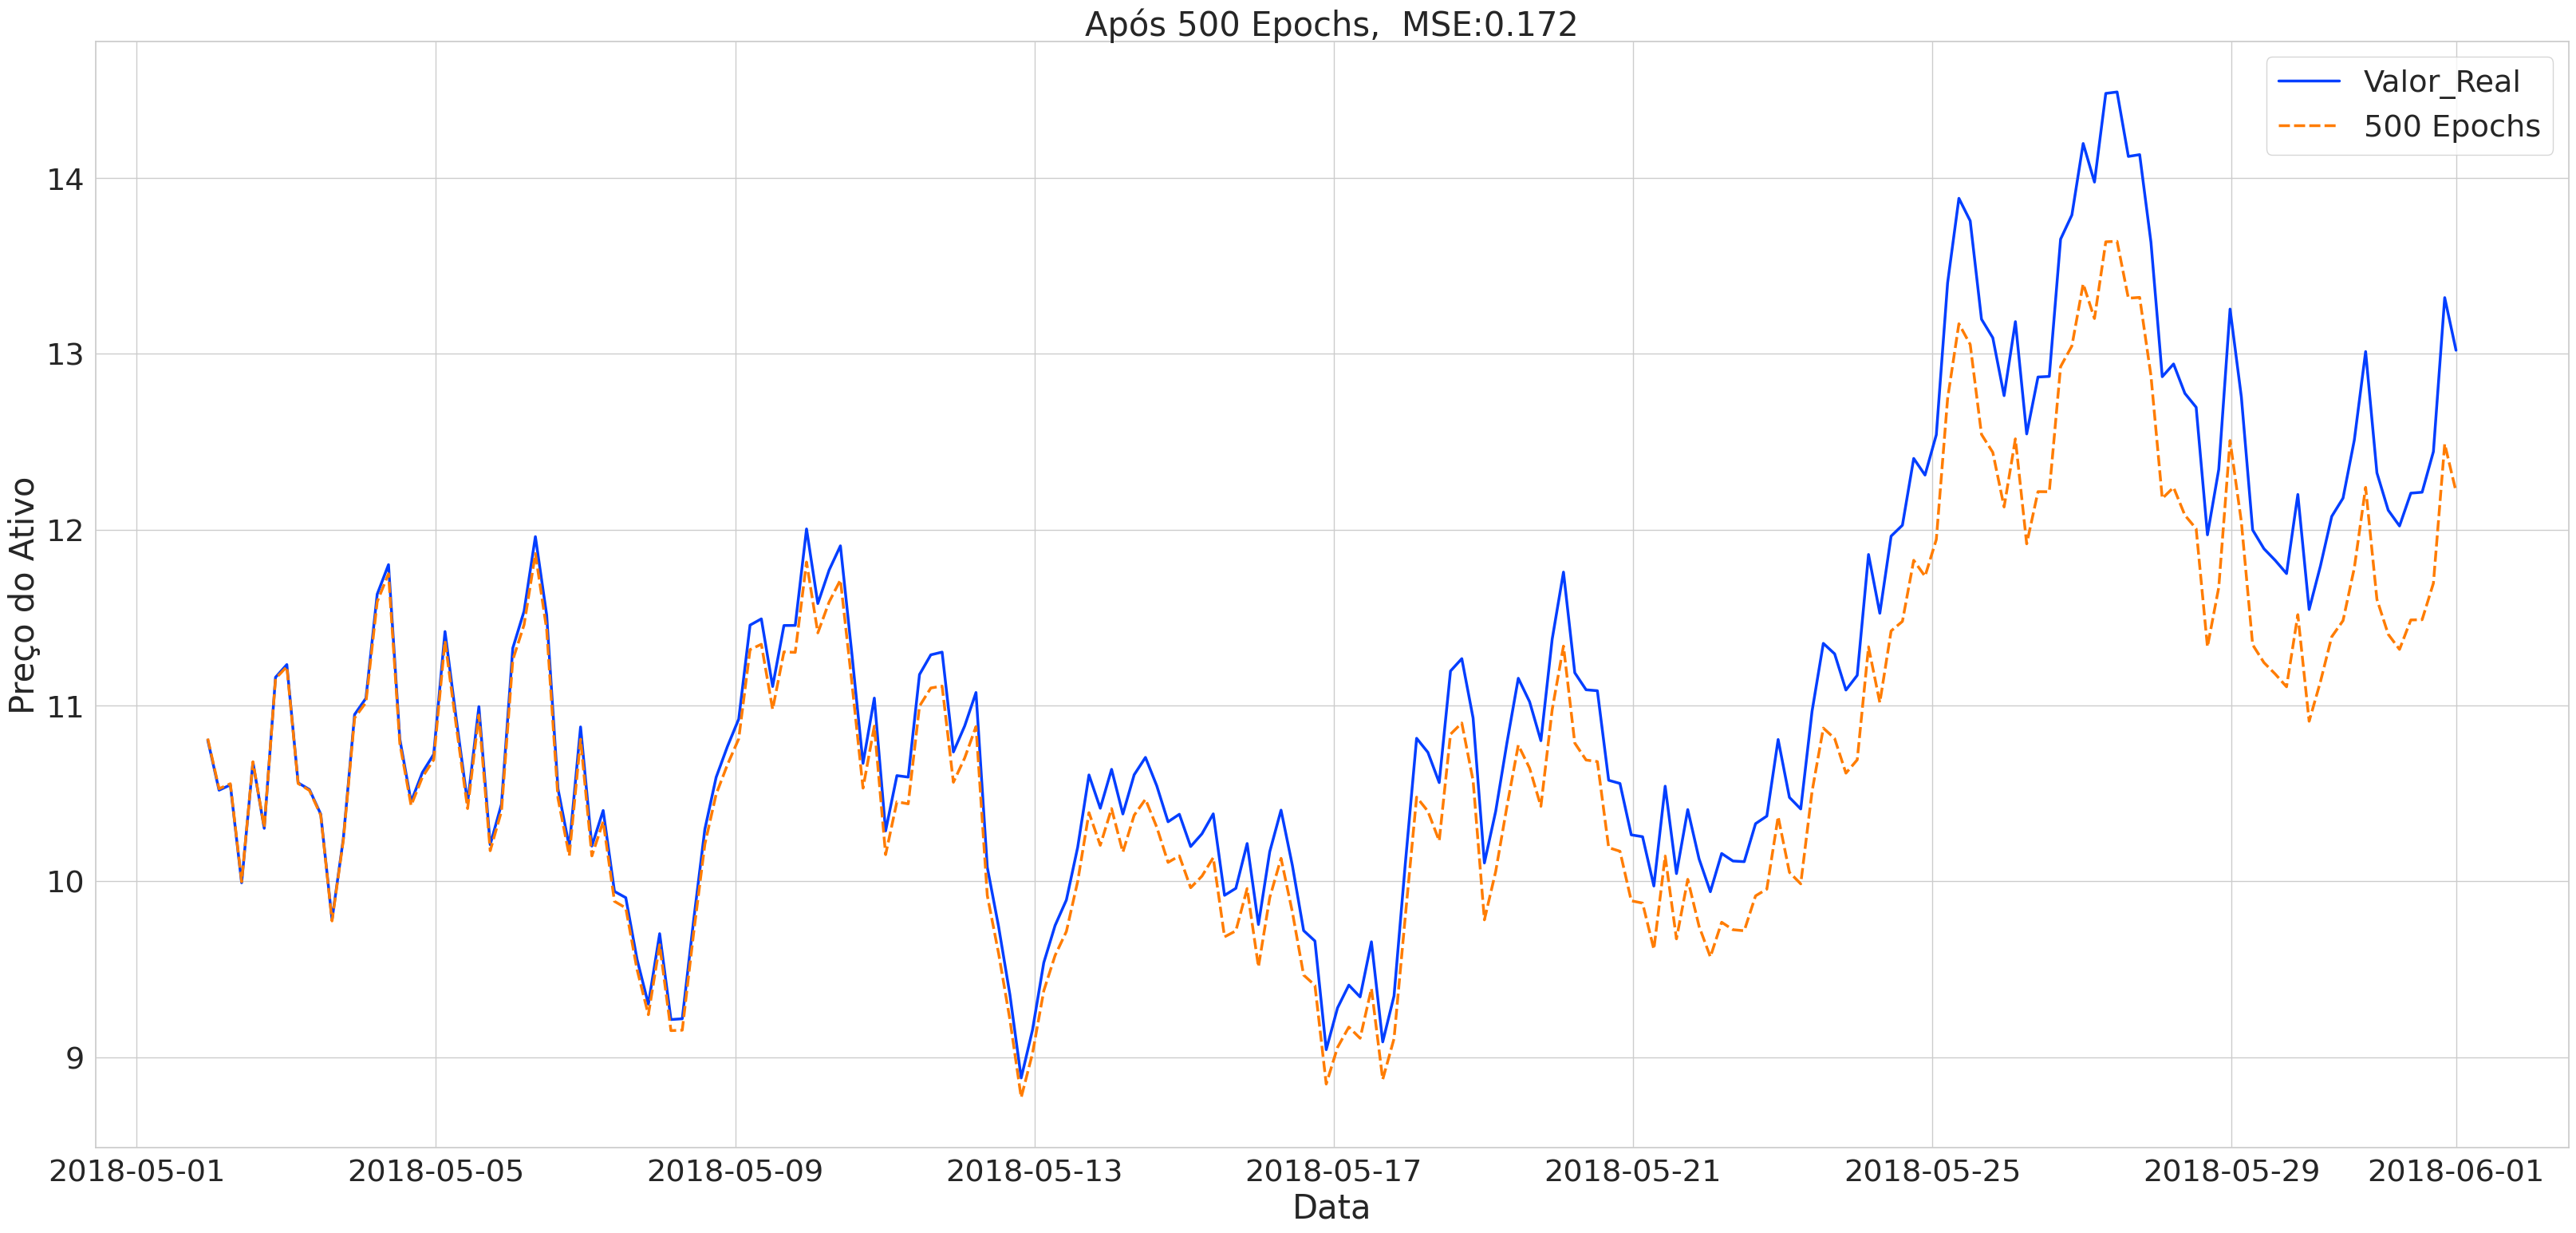

In [49]:
# Plot
plt.figure(figsize = (40, 18))
ax = sns.lineplot(data = all_preds[["Valor_Real", "500 Epochs"]], palette = "bright", linewidth = 2.5)
ax.set(xlabel = 'Data',
       ylabel = 'Preço do Ativo',
       title = f'Após 500 Epochs,  MSE:{round(mean_squared_error(all_preds.Valor_Real, all_preds["500 Epochs"]), 3)}')

[Text(0.5, 0, 'Data'),
 Text(0, 0.5, 'Preço do Ativo'),
 Text(0.5, 1.0, 'Após 1000 Epochs,  MSE:0.144')]

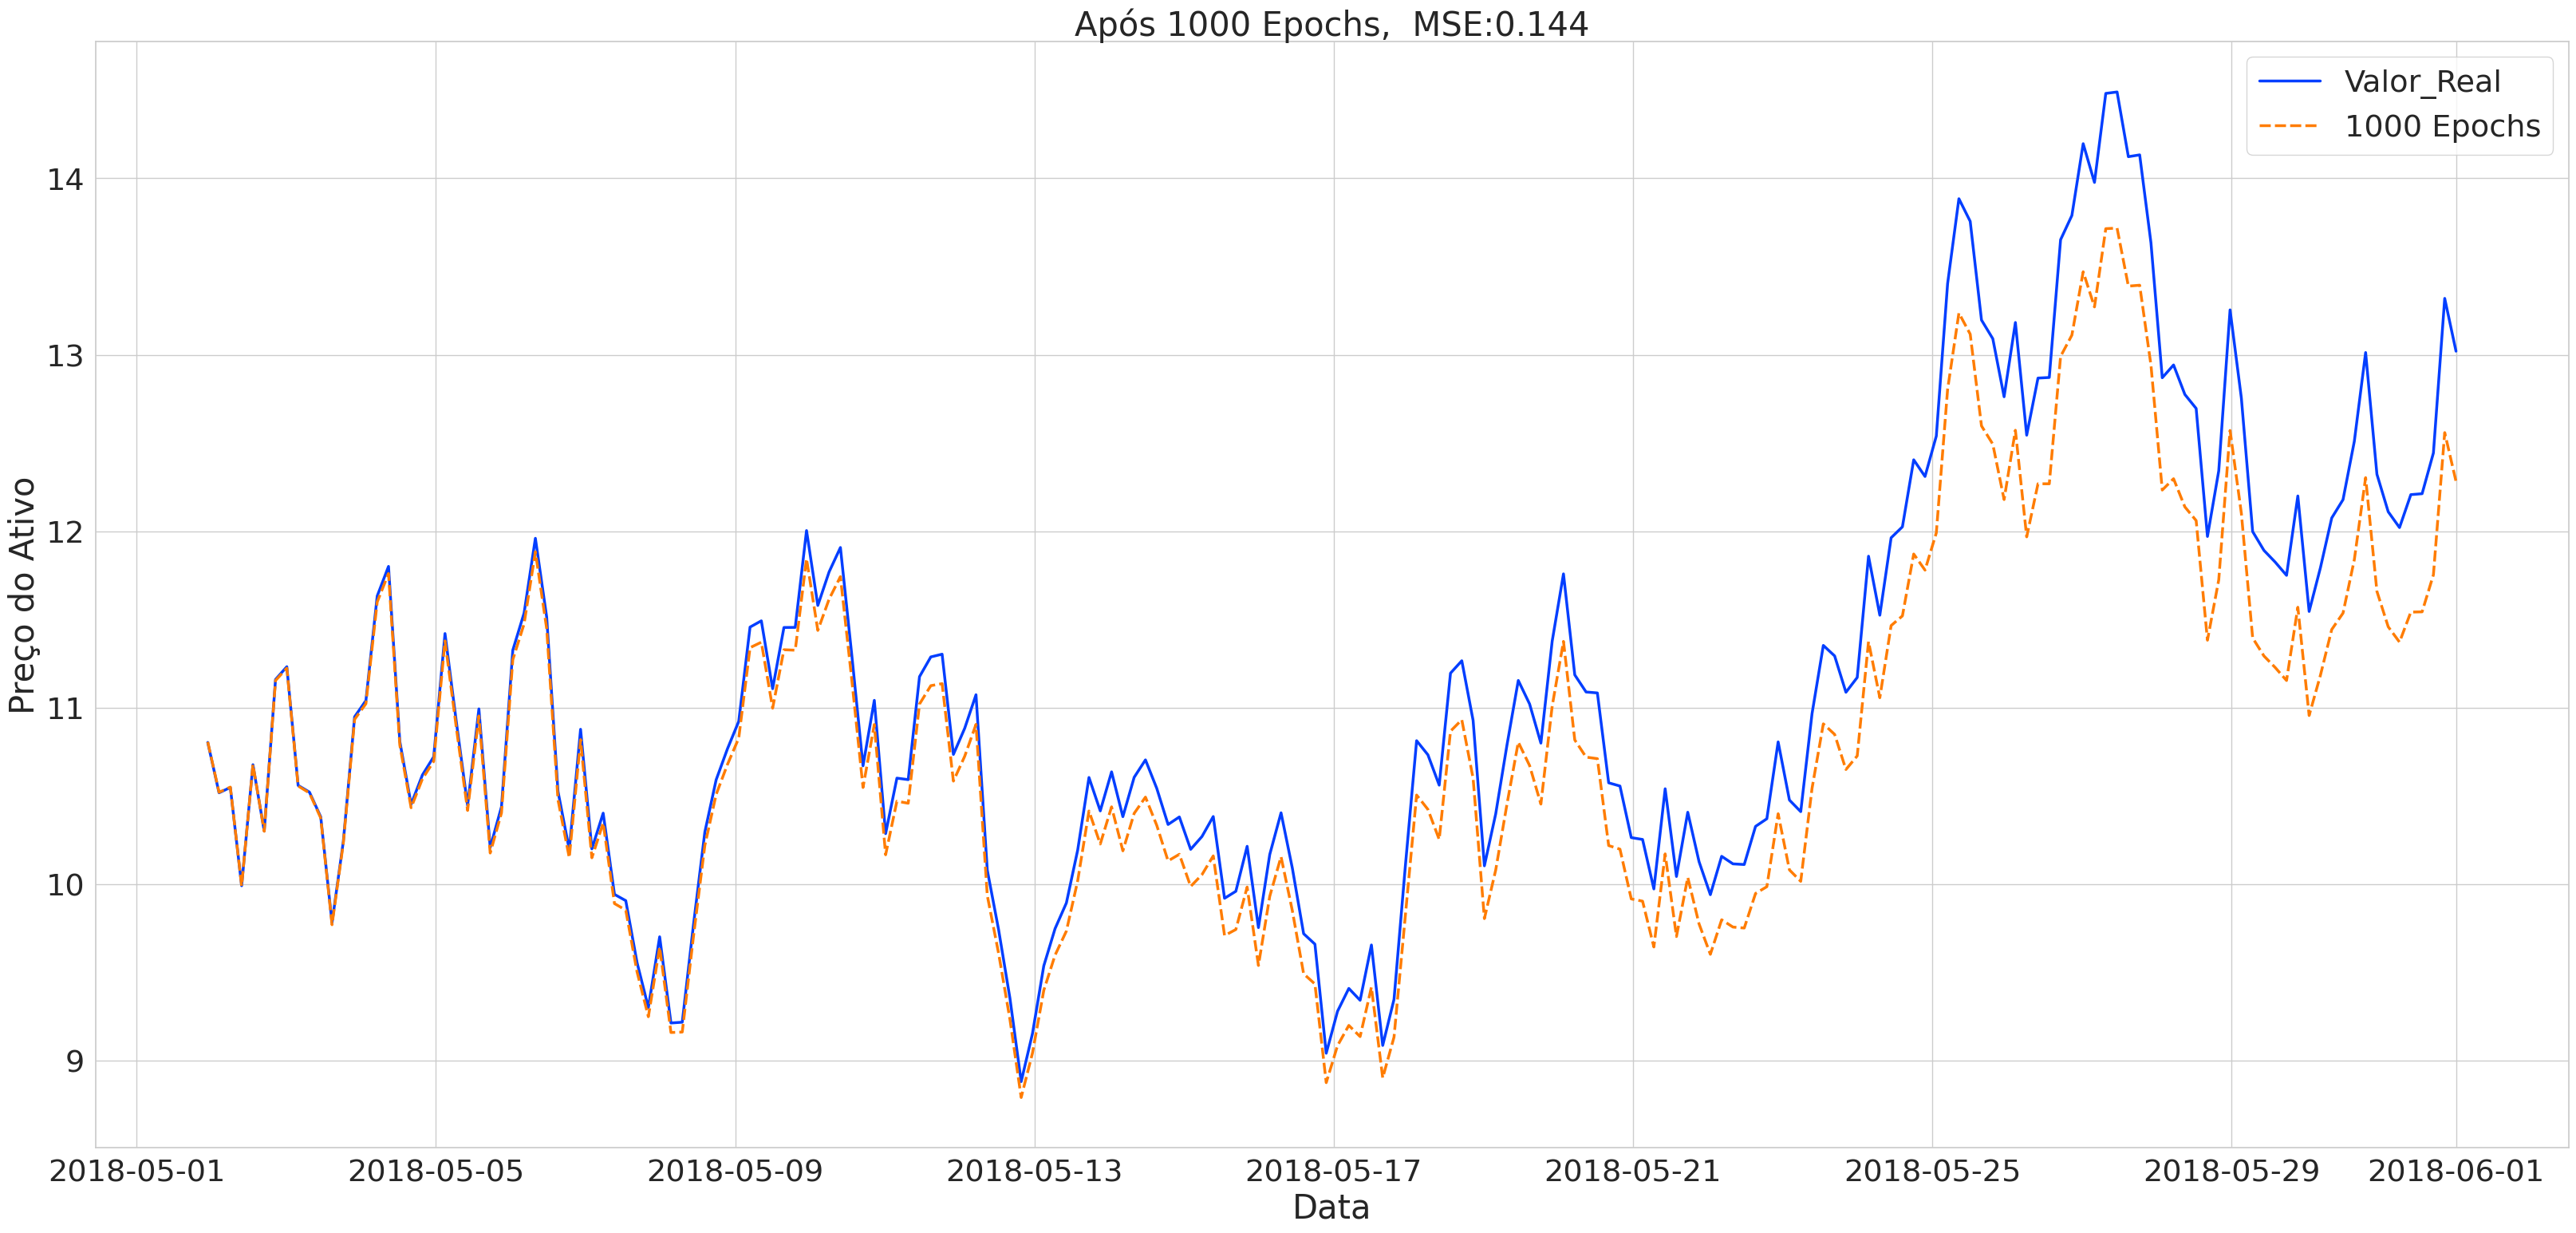

In [50]:
# Plot
plt.figure(figsize = (40, 18))
ax = sns.lineplot(data = all_preds[["Valor_Real", "1000 Epochs"]], palette = "bright", linewidth = 2.5)
ax.set(xlabel = 'Data',
       ylabel = 'Preço do Ativo',
       title = f'Após 1000 Epochs,  MSE:{round(mean_squared_error(all_preds.Valor_Real, all_preds["1000 Epochs"]), 3)}')

[Text(0.5, 0, 'Data'),
 Text(0, 0.5, 'Preço do Ativo'),
 Text(0.5, 1.0, 'Após 2000 Epochs,  MSE:0.135')]

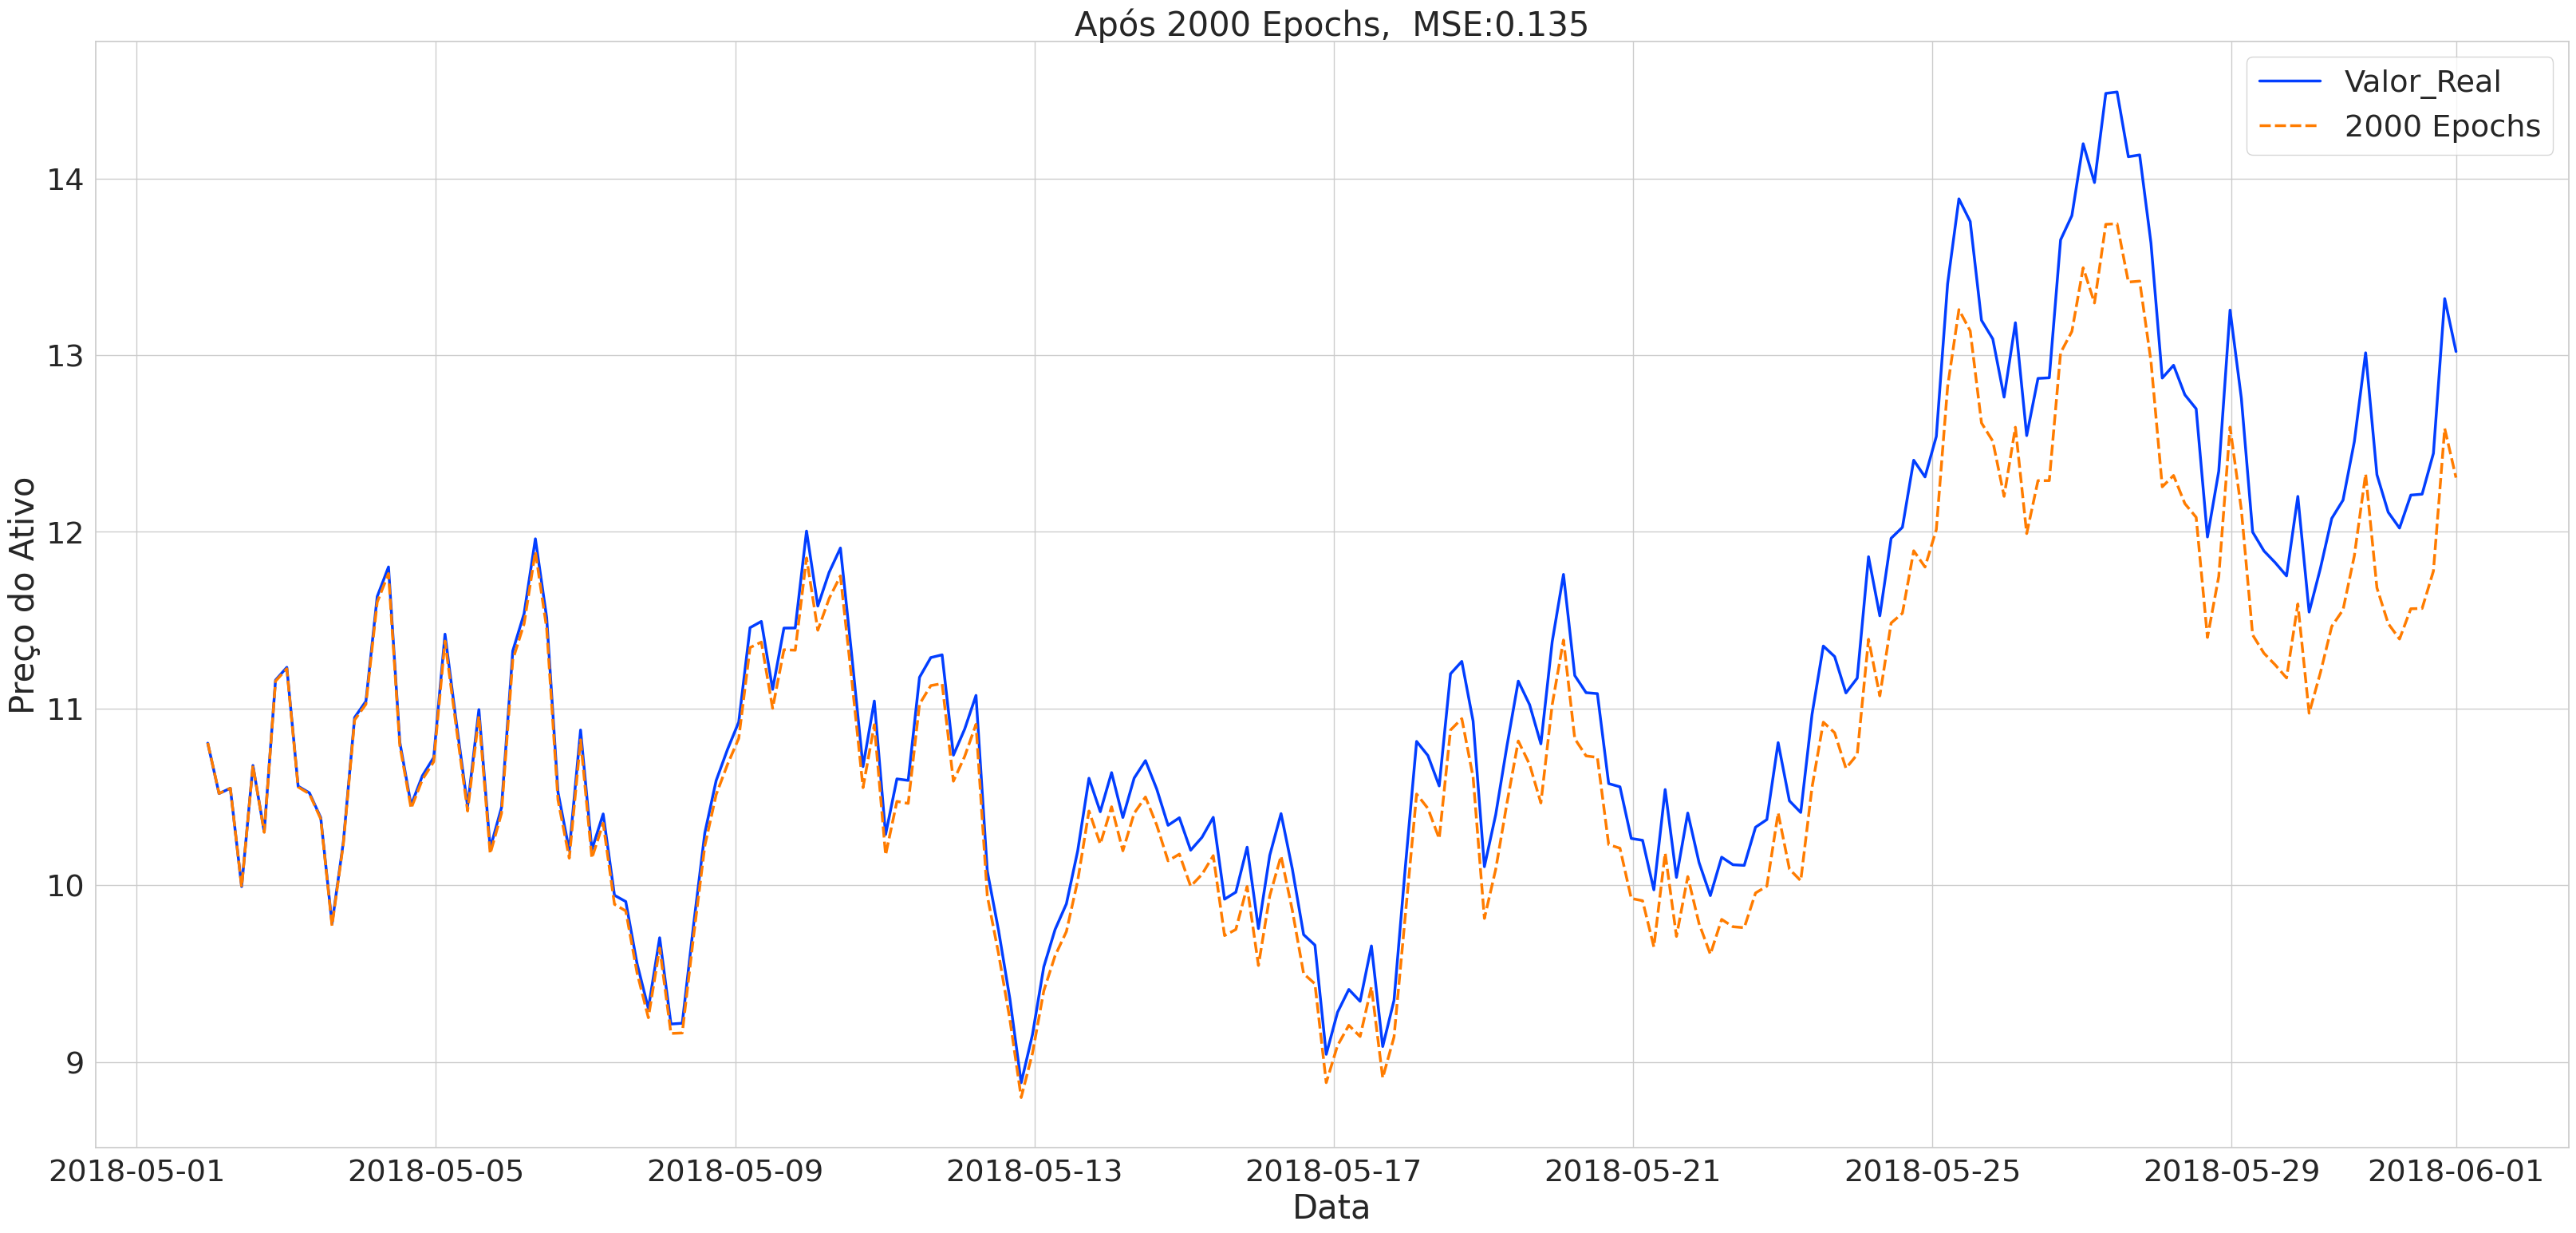

In [51]:
# Plot
plt.figure(figsize = (40, 18))
ax = sns.lineplot(data = all_preds[["Valor_Real", "2000 Epochs"]], palette = "bright", linewidth = 2.5)
ax.set(xlabel = 'Data',
       ylabel = 'Preço do Ativo',
       title = f'Após 2000 Epochs,  MSE:{round(mean_squared_error(all_preds.Valor_Real, all_preds["2000 Epochs"]), 3)}')

## Análise comparativa

<ipython-input-54-b23b83414501>:12: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=all_preds.index, y=all_preds["Valor_Real"], palette="bright", linewidth=2.5, label='Valor Real')
<ipython-input-54-b23b83414501>:16: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=all_preds.index, y=all_preds[f"{epochs} Epochs"], palette="bright", linewidth=2.5, label=f'{epochs} Epochs')
<ipython-input-54-b23b83414501>:16: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=all_preds.index, y=all_preds[f"{epochs} Epochs"], palette="bright", linewidth=2.5, label=f'{epochs} Epochs')
<ipython-input-54-b23b83414501>:16: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=all_preds.index, y=all_preds[f"{epochs} Epochs"], palette="bright", linewidth=2.5, label=f'{epochs} Epochs')
<ipython-input-54-b23b83414501>:16: UserWarning: Ignorin

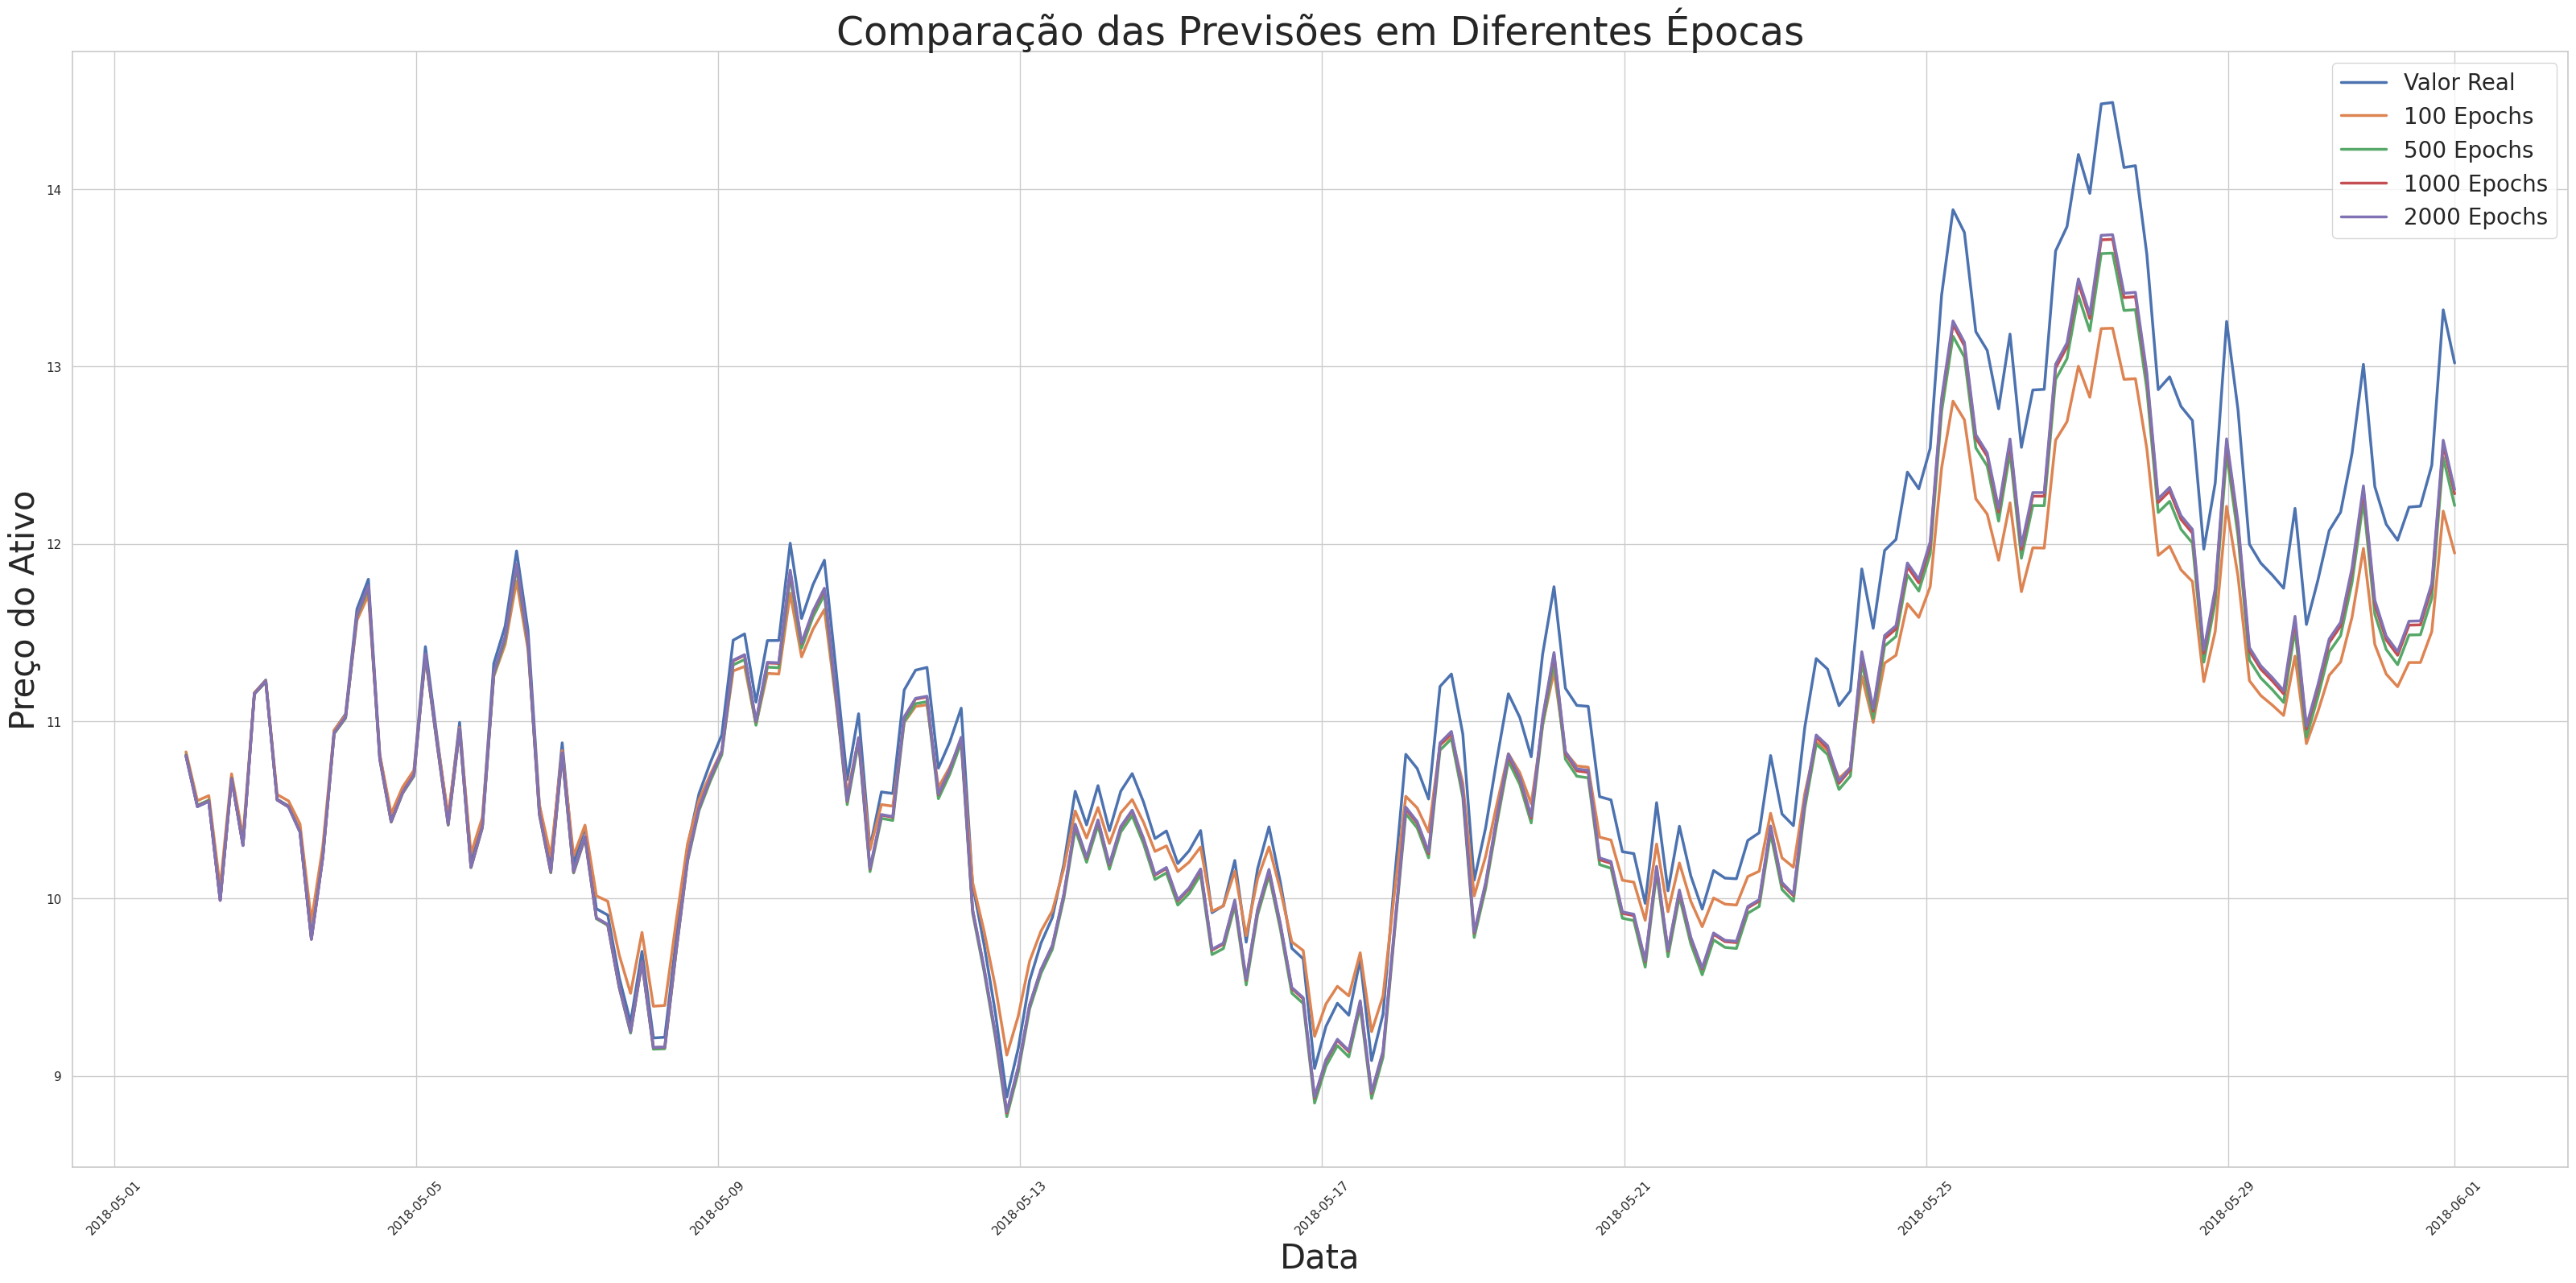

MSE após 100 Epochs: 0.249
MSE após 500 Epochs: 0.172
MSE após 1000 Epochs: 0.144
MSE após 2000 Epochs: 0.135


In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

# Configurações do estilo do Seaborn
sns.set(style="whitegrid")

# Criar figura
plt.figure(figsize=(40, 18))

# Adicionar a linha dos valores reais
sns.lineplot(x=all_preds.index, y=all_preds["Valor_Real"], palette="bright", linewidth=2.5, label='Valor Real')

# Adicionar as previsões para diferentes épocas
for epochs in [100, 500, 1000, 2000]:
    sns.lineplot(x=all_preds.index, y=all_preds[f"{epochs} Epochs"], palette="bright", linewidth=2.5, label=f'{epochs} Epochs')

# Adicionar rótulos e título
plt.xlabel('Data', fontsize=30)
plt.ylabel('Preço do Ativo', fontsize=30)
plt.title('Comparação das Previsões em Diferentes Épocas', fontsize=35)
plt.legend(fontsize=20)
plt.xticks(rotation=45)  # Rotacionar os rótulos do eixo x para melhor visualização
plt.show()

# Cálculo do MSE para cada número de épocas
for epochs in [100, 500, 1000, 2000]:
    mse = mean_squared_error(all_preds["Valor_Real"], all_preds[f"{epochs} Epochs"])
    print(f'MSE após {epochs} Epochs: {round(mse, 3)}')


## Tabela de Erros MSE

In [55]:
# Criar um DataFrame para os resultados de MSE
mse_results = {f'{epochs} Epochs': mean_squared_error(all_preds["Valor_Real"], all_preds[f"{epochs} Epochs"]) for epochs in [100, 500, 1000, 2000]}
mse_df = pd.DataFrame(mse_results.items(), columns=['Épocas', 'MSE'])
print(mse_df)

        Épocas       MSE
0   100 Epochs  0.249363
1   500 Epochs  0.172004
2  1000 Epochs  0.144330
3  2000 Epochs  0.135304


In [ ]:
mse_df.head()

## Gráfico de Erros MSE

<ipython-input-56-31cedfc25edd>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Épocas', y='MSE', data=mse_df, palette='viridis')


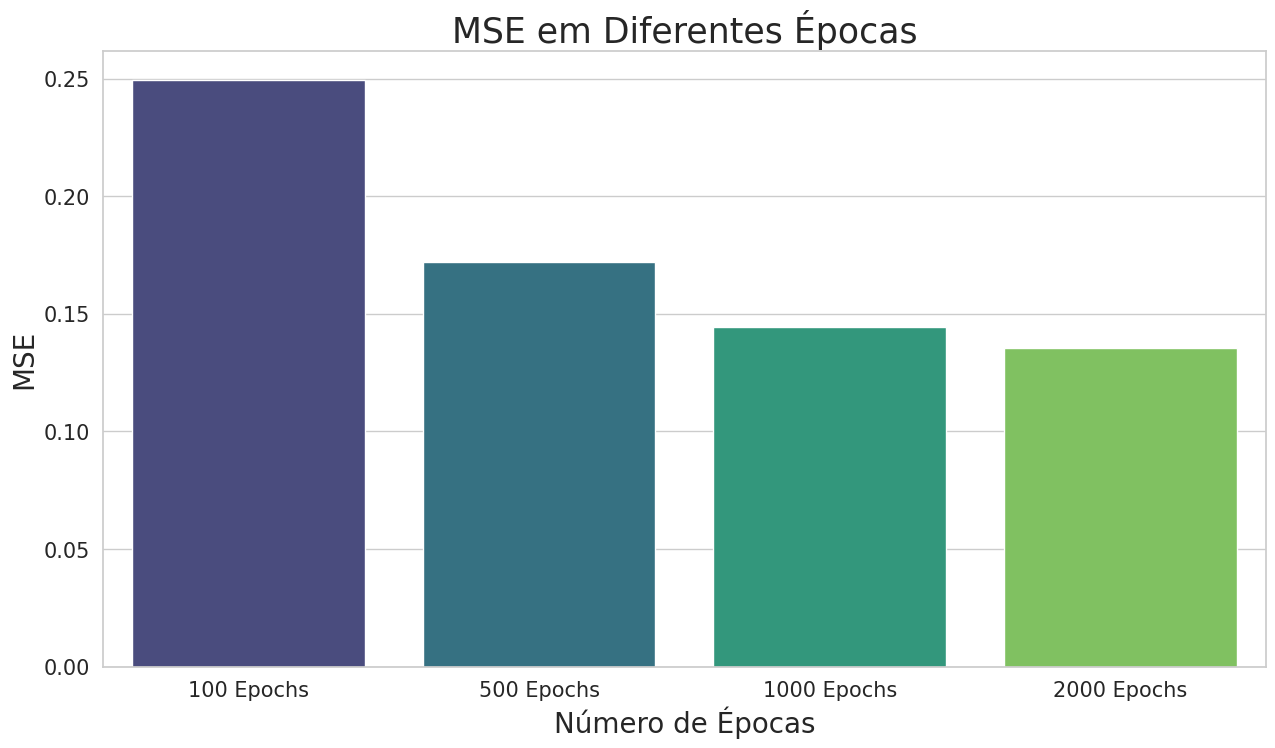

In [56]:
# Gráfico de barras para MSE
plt.figure(figsize=(15, 8))
sns.barplot(x='Épocas', y='MSE', data=mse_df, palette='viridis')
plt.xlabel('Número de Épocas', fontsize=20)
plt.ylabel('MSE', fontsize=20)
plt.title('MSE em Diferentes Épocas', fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

## Conclusão

Neste projeto, exploramos a aplicação do modelo Black, Merton e Scholes (BMS) para gerar dados sintéticos de preços de opções, com o objetivo de avaliar a eficácia de uma rede neural na previsão desses preços. Os dados simulados, incluindo variáveis como preço do ativo subjacente, maturidade, taxa livre de risco e volatilidade, foram utilizados como entrada para o treinamento do nosso modelo de rede neural.

Após o treinamento, o modelo foi avaliado para diferentes números de épocas: 100, 500, 1000 e 2000. Observamos que, à medida que o número de épocas aumentava, o desempenho do modelo melhorava, conforme evidenciado pela diminuição do erro quadrático médio (MSE) nas previsões. O gráfico de comparação entre os preços reais gerados pelo modelo BMS e as previsões do modelo de rede neural ilustra claramente essa tendência, destacando a capacidade do modelo em capturar a dinâmica dos preços das opções.

Os resultados mostraram que, após 2000 épocas de treinamento, a rede neural conseguiu aproximar-se de maneira significativa dos preços teóricos, sugerindo que o modelo é capaz de aprender padrões complexos nos dados. A análise de erros revelou que, em geral, o modelo apresentou um desempenho satisfatório, embora algumas discrepâncias tenham sido observadas em determinados intervalos de maturidade, o que pode ser atribuído à natureza estocástica do modelo BMS.

Essas descobertas enfatizam o potencial do uso de redes neurais na modelagem e previsão de preços de opções, oferecendo uma abordagem alternativa aos métodos tradicionais. O trabalho futuro pode incluir a incorporação de técnicas de regularização e otimização mais avançadas, bem como a exploração de diferentes arquiteturas de rede, para aprimorar ainda mais a precisão das previsões.

Além disso, a implementação de validação cruzada e o uso de conjuntos de dados mais extensos e diversificados podem fornecer insights adicionais sobre a robustez e a generalização do modelo. Com esses aprimoramentos, espera-se que as redes neurais possam se tornar uma ferramenta valiosa na avaliação de opções e na tomada de decisões financeiras.

